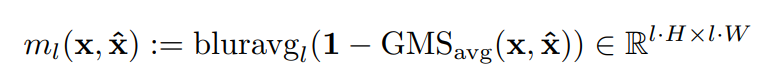

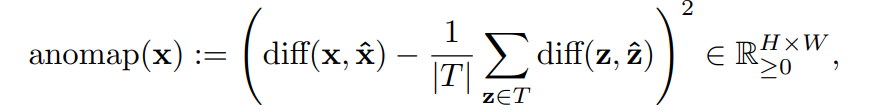

In [3]:
import torch
import torch.nn.functional as F
import math
from msgms import MSGMSLoss


def create_gaussian_kernel(kernel_size, sigma):
    """Create a Gaussian kernel."""
    gauss = torch.tensor([math.exp(-x**2 / (2 * sigma**2)) for x in range(-kernel_size//2 + 1, kernel_size//2 + 1)])
    gauss = gauss / gauss.sum()
    gauss = gauss.view(1, -1) * gauss.view(-1, 1)
    return gauss.view(1, 1, kernel_size, kernel_size)

def apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size=7, gauss_sigma=2):
    # Original spatial dimensions
    original_size = input_tensor.shape[-2:]

    # Create a uniform averaging kernel, adjusting for channel dimension
    channels = input_tensor.size(1)
    avg_kernel = torch.ones(channels, 1, scale_factor, scale_factor) / (scale_factor**2)
    avg_kernel = avg_kernel.to(input_tensor.device)

    # Apply convolution with stride equal to scale factor (for downsampling)
    downsampled_tensor = F.conv2d(input_tensor, avg_kernel, stride=scale_factor, padding=0, groups=channels)

    # Create Gaussian kernel
    gauss_kernel = create_gaussian_kernel(gauss_kernel_size, gauss_sigma).to(input_tensor.device)
    gauss_kernel = gauss_kernel.repeat(channels, 1, 1, 1)

    # Apply Gaussian blur
    smoothed_tensor = F.conv2d(downsampled_tensor, gauss_kernel, padding=gauss_kernel_size // 2, groups=channels)

    # Resize to original dimensions using bilinear interpolation
    resized_tensor = F.interpolate(smoothed_tensor, size=original_size, mode='bilinear', align_corners=False)

    return resized_tensor

def avg_multiscale(input_tensor, scale_factors=[1/2,1/4], gauss_kernel_size=7, gauss_sigma=2):
    smoothed_tensors = []
    for scale_factor in scale_factors:
        smoothed_tensors.append(apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size, gauss_sigma))
    stacked_tensor = torch.stack(smoothed_tensors, dim=0)
    diff = torch.mean(stacked_tensor, dim=0)   
    return diff

# get some metrics of a tensor
def met(tensor):
    return (f"{{'Max': {tensor.max().item():.2f},'Min': {tensor.min().item():.2f},'Mean': {tensor.mean().item():.2f},"f"'Sd': {tensor.std().item():.2f},"f"'Median': {tensor.median().item():.2f},"f"'Sum': {tensor.sum().item():.2f},"f"'Product': {tensor.prod().item():.2f}}}")


# Example usage
input_tensor = torch.randn(5, 1, 20, 20)  # Batch size of 5, 1 channel, 20x20 dimensions
final = avg_multiscale(input_tensor, scale_factors=[2, 4], gauss_kernel_size=5, gauss_sigma=2)
print(final.shape)  # Expected shape: (5, 1, 20, 20)


torch.Size([5, 1, 20, 20])


In [4]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


image1 = Image.open('/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/cable/train/good/005.png')
image_tensor1 = transform(image1)

image2 = Image.open('/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/cable/test/missing_cable/005.png')
image_tensor2 = transform(image2)

randomTensor = torch.randn(1, 3, 256, 256)
randomTensor = (randomTensor - randomTensor.min()) / (randomTensor.max() - randomTensor.min())


print(met(image_tensor1))
print(met(image_tensor2))
print(met(randomTensor))



{'Max': 1.00,'Min': 0.04,'Mean': 0.38,'Sd': 0.21,'Median': 0.34,'Sum': 75667.11,'Product': 0.00}
{'Max': 1.00,'Min': 0.05,'Mean': 0.40,'Sd': 0.23,'Median': 0.36,'Sum': 78860.31,'Product': 0.00}
{'Max': 1.00,'Min': 0.00,'Mean': 0.50,'Sd': 0.12,'Median': 0.50,'Sum': 97652.04,'Product': 0.00}


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


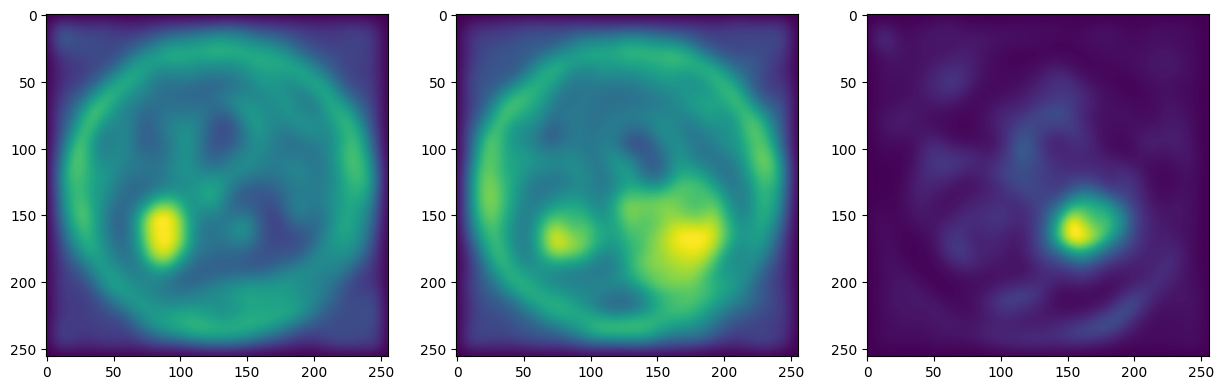

{'Max': 0.28,'Min': 0.00,'Mean': 0.11,'Sd': 0.05,'Median': 0.11,'Sum': 6978.23,'Product': 0.00}
{'Max': 0.27,'Min': 0.00,'Mean': 0.12,'Sd': 0.06,'Median': 0.12,'Sum': 7787.32,'Product': 0.00}
{'Max': 0.54,'Min': 0.00,'Mean': 0.05,'Sd': 0.07,'Median': 0.03,'Sum': 3289.12,'Product': 0.00}


In [5]:
msgms=MSGMSLoss()
loss, map =msgms(image_tensor1.unsqueeze(0),randomTensor)
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
diff_squared1 = diff**2

loss, map =msgms(image_tensor2.unsqueeze(0),randomTensor)
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
diff_squared2 = diff**2

# same image , difference should be zero
loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
diff_squared3 = diff**2

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(diff_squared1.squeeze(0).permute(1, 2, 0))
axs[1].imshow(diff_squared2.squeeze(0).permute(1, 2, 0))
axs[2].imshow(diff_squared3.squeeze(0).permute(1, 2, 0))
plt.show()


print(met(diff_squared1))
print(met(diff_squared2))
print(met(diff_squared3))


## Real Predicitons


In [6]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Good
good_real = Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/good_000_image.jpg')
image_tensor1 = transform(good_real)

good_pred = Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/good_000_recon.jpg')
image_tensor1_pred = transform(good_pred)

## anomaly
anomaly_real = Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/bent_wire_000_image.jpg')
image_tensor2 = transform(anomaly_real)

anomaly_pred= Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/bent_wire_000_recon.jpg')
image_tensor2_pred = transform(anomaly_pred)


print(met(image_tensor1))
print(met(image_tensor2))




{'Max': 1.00,'Min': 0.01,'Mean': 0.41,'Sd': 0.21,'Median': 0.36,'Sum': 80318.92,'Product': 0.00}
{'Max': 1.00,'Min': 0.02,'Mean': 0.41,'Sd': 0.22,'Median': 0.36,'Sum': 80179.88,'Product': 0.00}


In [18]:
map.shape

torch.Size([1, 1, 256, 256])

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


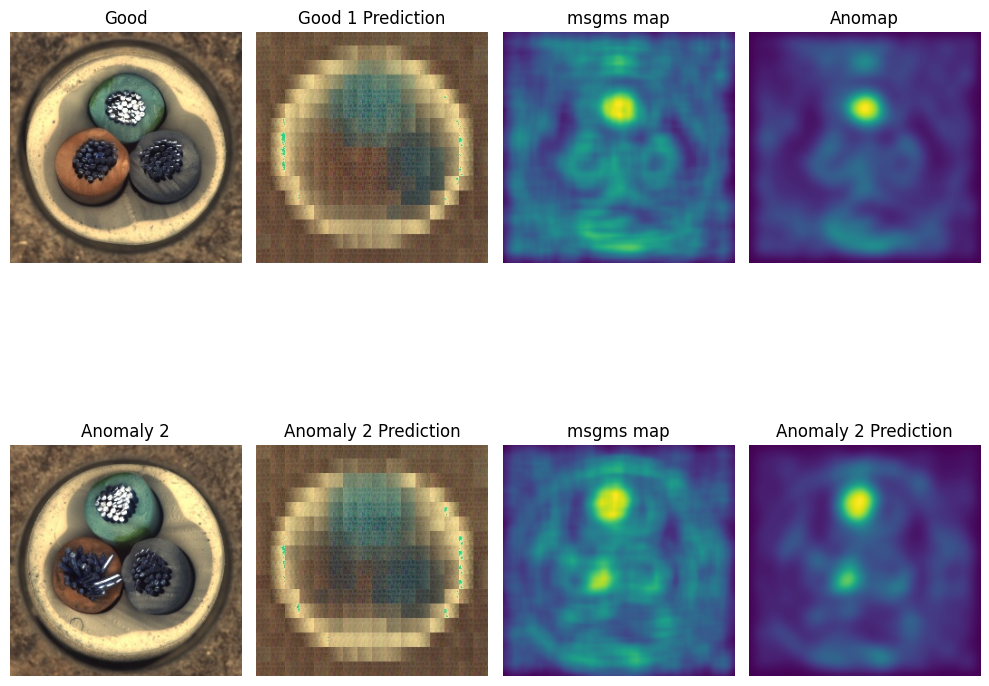

In [27]:
msgms=MSGMSLoss()
loss1, map1 =msgms(image_tensor1.unsqueeze(0),image_tensor1_pred.unsqueeze(0))
diff = avg_multiscale(map1, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
diff_squared1 = diff**2

loss2, map2 =msgms(image_tensor2.unsqueeze(0),image_tensor2_pred.unsqueeze(0))
diff = avg_multiscale(map2, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
diff_squared2 = diff**2

fig, axs = plt.subplots(2, 4, figsize=(10, 10))
axs[0, 0].imshow(image_tensor1.permute(1, 2, 0))
axs[0, 0].set_title('Good')
axs[0, 0].axis('off')  # Turn off axis

axs[0,1].imshow(image_tensor1_pred.permute(1, 2, 0))
axs[0, 1].set_title('Good 1 Prediction')
axs[0, 1].axis('off')

axs[0,2].imshow(map1.squeeze(0).permute(1, 2, 0))
axs[0, 2].set_title('msgms map' )
axs[0, 2].axis('off')

axs[0,3].imshow(diff_squared1.squeeze(0).permute(1, 2, 0))
axs[0, 3].set_title('Anomap' )
axs[0, 3].axis('off')


axs[1, 0].imshow(image_tensor2.permute(1, 2, 0))
axs[1, 0].set_title('Anomaly 2')
axs[1, 0].axis('off')

axs[1, 1].imshow(image_tensor2_pred.permute(1, 2, 0))
axs[1, 1].set_title('Anomaly 2 Prediction')
axs[1, 1].axis('off')


axs[1, 2].imshow(map2.squeeze(0).permute(1, 2, 0))
axs[1, 2].set_title('msgms map' )
axs[1, 2].axis('off')

axs[1, 3].imshow(diff_squared2.squeeze(0).permute(1, 2, 0))
axs[1, 3].set_title('Anomaly 2 Prediction')
axs[1, 3].axis('off')



plt.tight_layout()
plt.show()


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


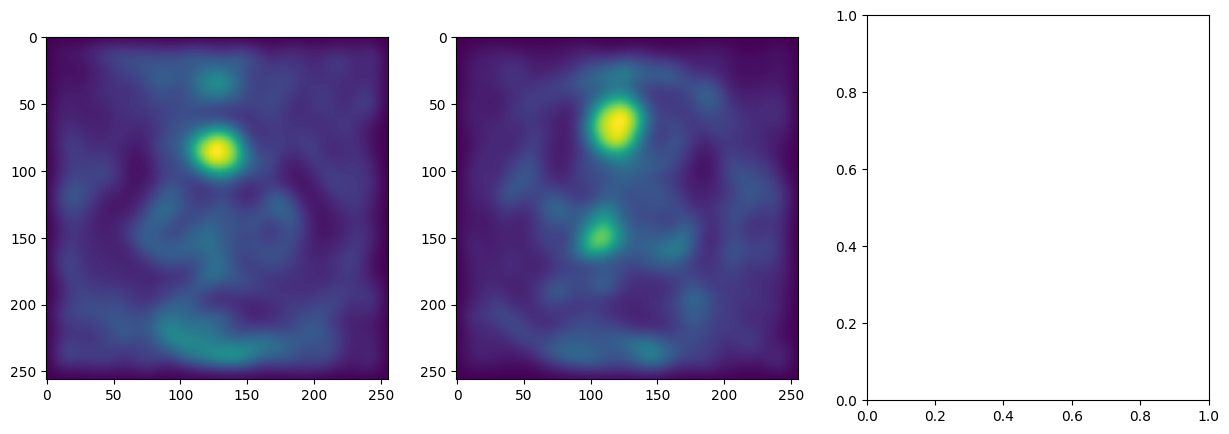

{'Max': 0.37,'Min': 0.00,'Mean': 0.07,'Sd': 0.04,'Median': 0.06,'Sum': 4436.86,'Product': 0.00}
{'Max': 0.36,'Min': 0.00,'Mean': 0.07,'Sd': 0.05,'Median': 0.06,'Sum': 4259.98,'Product': 0.00}


In [5]:
msgms=MSGMSLoss()
loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor1_pred.unsqueeze(0))
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
diff_squared1 = diff**2

loss, map =msgms(image_tensor2.unsqueeze(0),image_tensor2_pred.unsqueeze(0))
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
diff_squared2 = diff**2



fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(diff_squared1.squeeze(0).permute(1, 2, 0))
axs[1].imshow(diff_squared2.squeeze(0).permute(1, 2, 0))

plt.show()
print(met(diff_squared1))
print(met(diff_squared2))


In [6]:
import os

RES_PATH=f'/home/bule/projects/inpainting-transformer/ckpt/results'

types=['bent_wire','cable_swap','combined','cut_inner_insulation','cut_outer_insulation','missing_cable','missing_wire','poke_insulation']
good_real=[os.path.join(RES_PATH,img) for img  in os.listdir(RES_PATH) if 'good' in img and 'image'in img]
good_pred=[os.path.join(RES_PATH,img) for img  in os.listdir(RES_PATH) if 'good' in img and 'recon'in img]


ano_real=[os.path.join(RES_PATH,img) for img  in os.listdir(RES_PATH) if 'good' not in img and 'image'in img]
ano_pred=[os.path.join(RES_PATH,img)for img  in os.listdir(RES_PATH) if 'good' not in img and 'recon'in img]


In [13]:
good_max=[]
ano_max=[]

loss_good=[]
loss_ano=[]

msgms=MSGMSLoss()

for real,pred in zip(good_real,good_pred):
    image_tensor1 = transform(Image.open(real))
    image_tensor2 = transform(Image.open(pred))
    
    loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
    diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
    diff_squared1 = diff**2
    good_max.append(diff_squared1.max().item())
    
    loss_good.append(loss.item())
    
for real,pred in zip(ano_real,ano_pred):
    image_tensor1 = transform(Image.open(real))
    image_tensor2 = transform(Image.open(pred))    
    
    loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
    diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
    diff_squared1 = diff**2
    ano_max.append(diff_squared1.max().item())
    
    loss_ano.append(loss.item())
    

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1,

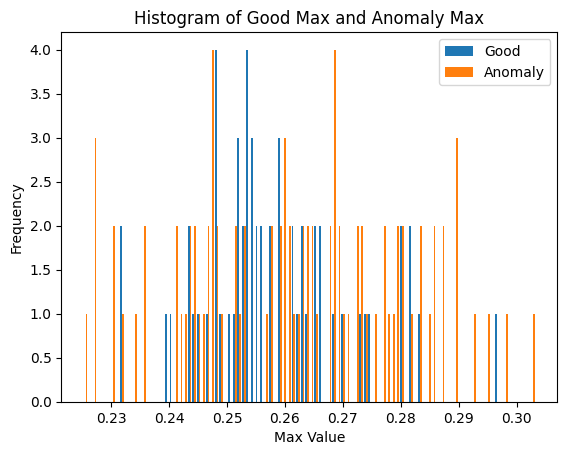

In [14]:
plt.hist([loss_good, loss_ano], bins=100, label=['Good', 'Anomaly'])
plt.xlabel('Max Value')
plt.ylabel('Frequency')
plt.title('Histogram of Good Max and Anomaly Max')
plt.legend()
plt.show()

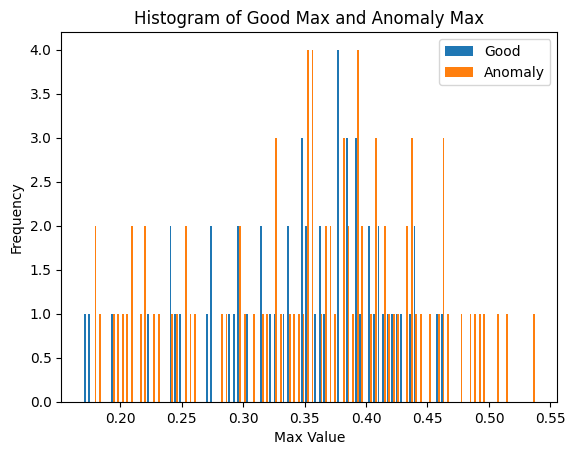

In [12]:
import matplotlib.pyplot as plt

plt.hist([good_max, ano_max], bins=100, label=['Good', 'Anomaly'])
plt.xlabel('Max Value')
plt.ylabel('Frequency')
plt.title('Histogram of Good Max and Anomaly Max')
plt.legend()
plt.show()


## conclusions
darker regions with lowe3r values get higher score when the reconstruction is random 



